# Virtual Distillation
We perform the full protocol for the 3-copies case, and check the behavior under some noise models.

In [2]:
import qutip
RUN_ALL = False

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

N = 9 # Total dimension of the space. We will use three copies so N^3 size matrices

### Initial noisy Fock state

Kraus operators $\hat A_k(t)=\dfrac{(1-e^{-\kappa t})^{k/2}}{\sqrt{k!}}e^{-\kappa \hat n t/2}\hat a^k$.
$$\hat\rho(t)=\sum_{k=0}^\infty\hat A_k(t)\hat\rho_0\hat A_k(t)^\dagger$$

with $\rho_0=\ket n\bra n$

For multi-mode $\hat a, \hat b, \dots,\hat c$ we define the same way $\hat A_k, \hat B_k,\dots \hat C_k$ and
$$\hat\rho(t)=\sum_{k=0}^\infty\sum_{l=0}^\infty\dots\sum_{m=0}^\infty\hat A_k\hat B_l\dots\hat C_m\hat\rho_0 \hat A_k^\dagger\hat B_l^\dagger\dots\hat C_m^\dagger$$

In [4]:
n = 3
T_1 = 500 # μs
kappa = 1/T_1 #
t_max = 30 # μs (such that κt~0.01-0.1)

nb_samples = 20
t_list = np.linspace(0,t_max,nb_samples)

def kraus_op(k, t, nb_copies, id_copy):
    # returns Kraus operator as defined above
    # for multimode (nb_copies > 1), returns 1 x … x 1 x A_k x … x 1 with A_k in id_copy position
    op = (-kappa*t/2*qutip.num(N)).expm()
    op = op * qutip.destroy(N)**k
    prefactor = (1-np.exp(-kappa*t))**(k/2)/(np.sqrt(math.factorial(k)))
    op = prefactor * op
    return qutip.tensor([qutip.identity(N)]*(id_copy) + [op] + [qutip.identity(N)]*(nb_copies-id_copy-1))

# Creation of the states
def create_states(t_list:np.ndarray, rho_0:qutip.qobj.Qobj, nb_copies:int=1) -> list[qutip.qobj.Qobj]:
    ''' Applies the loss channel to the state rho_0 and returns the temporal evolution
    
    Input :
       t_list : np.ndarray[float]  (size m) list with the input times
       rho_0 : qutip.qobj.Qobj    initial state
       nb_copies : int            number of copies on which to apply the loss channel
    Output :
      rho_list : list[qutip.qobj.Qobj] (size m)  list of noisy states'''

    rho_list = []
    for t in t_list:
        rho_init = rho_0
        for id_copy in range(nb_copies):
            rho = qutip.tensor([qutip.Qobj(np.zeros((N,N)))]*nb_copies) # 0 matrix
            for k in range(N): # not useful to go beyond N, the operator is 0
                kraus = kraus_op(k, t, nb_copies, id_copy)
                rho = rho + kraus * rho_init * kraus.dag()
            rho_init = rho
        rho_list.append(rho)
    return rho_list
    
rho_list = create_states(t_list, rho_0 = qutip.fock_dm(N,n))

#rho_full = qutip.tensor([qutip.fock_dm(N,n)]*3)
#rho_1_noisy = create_states([0.1], rho_full, 3)

Because the resulting initial states are diagonal in the Fock basis, i.e. of the form $\sum_kc_k\ket k\bra k$, we can represent them using a bar chart of the coefficients $c_k$.

Text(0.5, 1.0, 't=30.000')

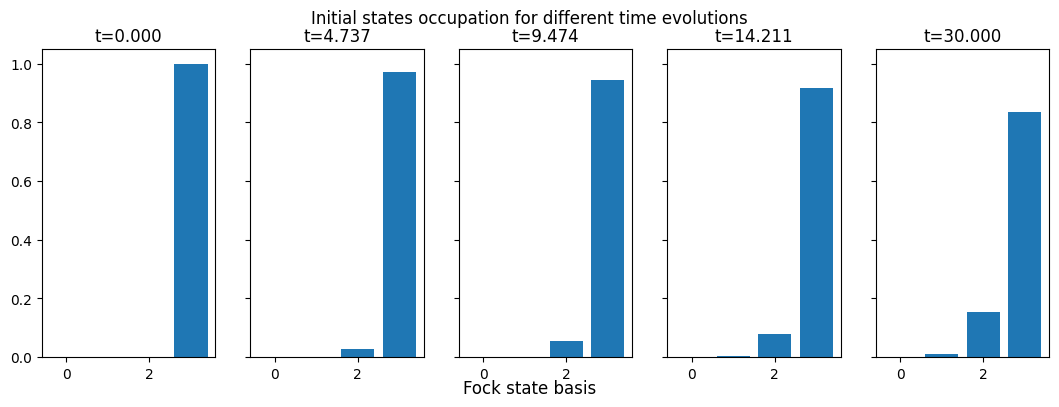

In [5]:
nb_plots = 4
f, axes = plt.subplots(1, nb_plots+1, sharey=True, figsize=(13,4))
f.suptitle("Initial states occupation for different time evolutions")
f.supxlabel("Fock state basis")
for i in range(nb_plots):
    axes[i].bar(np.arange(n+1),np.abs(np.diag(rho_list[3*i]))[:n+1])
    axes[i].set_title(f't={t_list[3*i]:.3f}')
axes[nb_plots].bar(np.arange(n+1),np.abs(np.diag(rho_list[nb_samples-1]))[:n+1])
axes[nb_plots].set_title(f't={t_list[nb_samples-1]:.3f}')

In [6]:
sigma = qutip.tensor([qutip.fock_dm(N,2)]*3)
sigma_noisy = create_states([0.1], sigma, 3)[0]
sigma_noisy.tr()

0.9999999999999759

### Virtual Distillation protocol
We perform the protocol for $M=3$ copies of the noisy input state using the diagonalizing method. This is done by applying three successive beam splitter operations on the 3-mode system, resulting in the following gate:
$$\hat{\mathcal F}_3=e^{\frac{i\pi}4(\hat a_1^\dagger \hat a_2+\hat a_2^\dagger \hat a_1)}e^{i\arcsin{(\frac1{\sqrt3})}(\hat a_3^\dagger \hat a_2+\hat a_2^\dagger \hat a_3)}e^{\frac{i\pi}4(\hat a_3^\dagger \hat a_1+\hat a_1^\dagger \hat a_3)}$$

To assess the robustness of the protocol, we add some coherent error on the angle of the beam splitter, modelized by a Gaussian distribution.

$$\hat{\mathcal F}_3(\varepsilon)=e^{i\left(\frac{\pi}4+\varepsilon_1\right)(\hat a_1^\dagger \hat a_2+\hat a_2^\dagger \hat a_1)}e^{i\left(\arcsin{(\frac1{\sqrt3})}+\varepsilon_2\right)(\hat a_3^\dagger \hat a_2+\hat a_2^\dagger \hat a_3)}e^{i\left(\frac{\pi}4+\varepsilon_3\right)(\hat a_3^\dagger \hat a_1+\hat a_1^\dagger \hat a_3)}$$
with
$$\varepsilon=(\varepsilon_1,\varepsilon_2,\varepsilon_3)\sim \mathcal N(0,\sigma)$$

We also consider uncoherent losses during the protocol in between each beam splitter gate, which are however proven to commute with the beam splitter operators, so the expected curve should appear as shifted to the left compared to the one without losses.

In [7]:
a1 = qutip.tensor(qutip.destroy(N),  qutip.identity(N), qutip.identity(N))
a2 = qutip.tensor(qutip.identity(N), qutip.destroy(N),  qutip.identity(N))
a3 = qutip.tensor(qutip.identity(N), qutip.identity(N), qutip.destroy(N))
n1 = qutip.tensor(qutip.num(N),  qutip.identity(N), qutip.identity(N))
n2 = qutip.tensor(qutip.identity(N), qutip.num(N),  qutip.identity(N))
n3 = qutip.tensor(qutip.identity(N), qutip.identity(N), qutip.num(N))

def create_F3(sines, noise):
    # takes as input an array with the sines of the three beam splitter angles
    # a perfect F3 corresponds to s1=s3=1/sqrt(2) and s2=1/sqrt(3)
    # returns the three beam splitters in order 
    t1, t2, t3 = np.arcsin(sines) + noise
    bs1 = (1j*t1*(a1.dag()*a2 + a2.dag()*a1)).expm()
    bs2 = (1j*t2*(a3.dag()*a2 + a2.dag()*a3)).expm()
    bs3 = (1j*t3*(a1.dag()*a3 + a3.dag()*a1)).expm()
    return bs1, bs2, bs3

# redifining the modes up to global phase (useless)

#left_redef  = (-2j*np.pi/3*n1 - 5j*np.pi/6*n2 ).expm()
#right_redef = (-1j*np.pi/2*n1 - 1j*np.pi/2*n2).expm()

Here is where we compute the noisy $\mathcal F_3$ gates (this is the most costly operation). We will then average the results and compute their standard deviation.

In [8]:
nb_F_samples = 50
eps_std = 0.03
initial_sin_angles = np.sqrt((1/2,1/3,1/2))

try: # to avoid recalculating everything when rerunning only some of the cells of the Notebook
    recalc = not recalc
except NameError:
    if RUN_ALL:
        noise_list = np.random.normal(0,eps_std,(nb_F_samples,3))
        F_list = [] # list of triplets of beam splitters
        for (i,noise) in enumerate(noise_list):
            if (i%1==0): print(f"{i+1}/{nb_F_samples}", end=" ")
            F_list.append(create_F3(initial_sin_angles, noise))
        recalc = False

After applying the diagonalizing gate, we obtain
$$\tilde \rho=\hat{\mathcal F}_3\rho^{\otimes 3}\hat{\mathcal F}_3^\dagger$$
We can then measure $\hat n_1$, $\hat n_2$, $\hat n_3$ and by repeating the experiment retrieve
$$ \operatorname{den}=\left\langle\hat{\mathcal R_3}\right\rangle =\left\langle\exp\left(\frac{2i\pi}3(\hat n_1+2\hat n_2)\right)\right\rangle \quad\text{and}\quad \operatorname{num}=\left\langle\hat n^{(3)}\hat{\mathcal R_3}\right\rangle = \left\langle\frac{\hat n_1+\hat n_2+\hat n_3}3e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle$$
Instead of averaging on many experiments, here we directly compute the expectation values (this should be faster thanks to qutip).
We compare
$$\frac{\operatorname{num}}{\operatorname{den}}\;,\quad \frac{\operatorname{tr}\left(\hat n\hat\rho^3\right)}{\operatorname{tr}\left(\hat\rho^3\right)}\;,\quad\text{and}\quad \operatorname{tr}(\hat n\hat\rho)$$
which correspond to computed result, theoretical result and no-VD result.

$$\Rightarrow\left\langle\hat n\right\rangle_{VD}=\frac{\left\langle\frac{\hat n_1+\hat n_2+\hat n_3}3e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle}{\left\langle e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle}$$

In [9]:
# define the operators
denominator_op = (2j*np.pi/3*(n1+2*n2)).expm()
numerator_op = (n1+n2+n3)/3 * denominator_op
uncoherent_t_loss = 5 # μs value chosen arbitrarily, total expected shift

def perform_protocol(rho_list : list[qutip.qobj.Qobj], F_list : list[tuple[qutip.qobj.Qobj]], M_list : list[int] =[3,4,1], losses = True) -> tuple[np.ndarray]:
    ''' Performs the full 3-mode VD protocol on each input state and for each noisy F_3 gate
    Returns the 2-dimensional array with all results. Also returns theoretical results for comparison (see plots)
    
    Input :
       rho_list : list[qutip.qobj.Qobj]  (size n)  list of input states
       F_list :   list[tuple[qutip.qobj.Qobj]]  (size m) list of noisy beam splitters forming the F_3 gate
       M_list :   list[int]              (size k) list of nb_modes for theoretical results
    Output :
       result :    np.array (size (n, m))  numerical results of the simulation
       result_loss : np.array (size (n,m)) adding losses in between
       result_th : np.array (size (k, n))  theoretical results for a perfect protocol (default: 3-mode, 4-mode and single-mode)
    '''

    nb_samples = len(rho_list)
    result = np.zeros((nb_samples, len(F_list)), dtype='complex')
    result_loss = np.zeros((nb_samples, len(F_list)), dtype='complex')
    result_th = np.zeros((len(M_list), nb_samples), dtype='complex')

    
    t_loss = uncoherent_t_loss

    for (i,rho) in enumerate(rho_list):
        # create the 3 copies
        rho_full = qutip.tensor([rho]*3)
        for (j,(bs1, bs2, bs3)) in enumerate(F_list):
            # apply the F_3 gate
            F3 = bs1 * bs2 * bs3 # no losses in between beam splitters
            rho_tilde = F3 * rho_full * F3.dag()
            # compute the expectation values
            numerator = qutip.expect(numerator_op, rho_tilde)
            denominator = qutip.expect(denominator_op, rho_tilde)
            result[i,j]=(numerator/denominator)
            # WITH losses
            if losses:
                rho_1 = bs3 * rho_full * bs3.dag()
                rho_1_noisy = create_states([t_loss/3], rho_1, 3)[0]
                rho_2 = bs2 * rho_1_noisy * bs2.dag()
                rho_2_noisy = create_states([t_loss/3], rho_2, 3)[0]
                rho_3 = bs1 * rho_2_noisy * bs1.dag()
                rho_3_noisy = create_states([t_loss/3], rho_3, 3)[0]
                result_loss[i,j] = qutip.expect(numerator_op, rho_3_noisy)/qutip.expect(denominator_op, rho_3_noisy)
        # theoretical results
        for (k, nb_mode) in enumerate(M_list):
            result_th[k,i] = (qutip.num(N)* rho**nb_mode).tr() / (rho**nb_mode).tr()

    return result, result_loss, result_th

if RUN_ALL:
    result, result_loss, result_th = perform_protocol(rho_list, F_list, losses=False)
    result_th_3, result_th_4, result_withoutVD = result_th

We have to be careful that the numerical errors coming from truncation of Hilbert space are not too important : check that S is doing the appropriate thing (only zeroes and ones should appear below (up to phase))

In [10]:
bs1, bs2, bs3 =create_F3(initial_sin_angles, np.zeros(3))
F3 = bs1*bs2*bs3
S3 = F3.dag() * denominator_op * F3
print(S3.check_isunitary()) # this should be equal to the shift operator

for i in range(3):
    x = [n-1 if i==0 else n, n-1 if i==1 else n, n-1 if i==2 else n]
    for j in range(3):
        y = [n-1 if j==0 else n, n-1 if j==1 else n, n-1 if j==2 else n]
        print(f"<{x[0]}{x[1]}{x[2]}|S|{y[0]}{y[1]}{y[2]}> = ",
            ((qutip.fock([N,N,N],x).dag() * S3 * qutip.fock([N,N,N],y)).data.toarray()[0][0]))

True
<233|S|233> =  0j
<233|S|323> =  0j
<233|S|332> =  1j
<323|S|233> =  (0.9999999999999998+0j)
<323|S|323> =  0j
<323|S|332> =  0j
<332|S|233> =  0j
<332|S|323> =  -0.9999999999999996j
<332|S|332> =  0j


### Plots

In [11]:
def plot_all(t_list :np.ndarray, result :np.ndarray, result_loss: np.ndarray, result_th_wlabels: list, 
             remove_extreme : None | tuple[int] = None, title:str="Fock state", show_curves:bool=False, losses=True) -> None:
    ''' Creates the plots with the given results
    
    Input:
        t_list : np.ndarray[float]   size (n)    list of x-axis coordinates
        result : np.ndarray[complex] size (n, m) array of numerical VD results
        result_loss : np.ndarray[complex] size (n,m) same with inter-losses between beam splitters
        result_th_wlabels : list[tuple[np.ndarray size (n), string]]   Other theoretical results for comparison
        remove_extreme : None | tuple[int]   gives a range of values to keep
        title : string            type of input states we are looking at
        show_curves : bool       exact solutions for Fock state theoretical curves
    '''
    if (remove_extreme is None):
        result_corr = result
        result_loss_corr = result_loss
    else :
        #remove extreme points
        extr_max, extr_min = remove_extreme
        result_corr = result[:, np.all(np.logical_and(np.abs(result)<extr_max, np.abs(result)>extr_min),0)]
        result_loss_corr = result_loss[:, np.all(np.logical_and(np.abs(result_loss)<extr_max, 
                                                                np.abs(result_loss)>extr_min),0)]
    colors = ['green', 'blue', 'pink', 'orange', 'red', 'gray', 'black']
    plt.errorbar(t_list, np.abs(result_corr.mean(1)), result_corr.std(1), np.zeros_like(t_list), 
                    barsabove=True, elinewidth=.5,fmt='.',label="VD (3 copies) coherent noise", c=colors[0], capsize=3)
    if losses:
        plt.errorbar(t_list, np.abs(result_loss_corr.mean(1)), result_loss_corr.std(1), np.zeros_like(t_list), 
                    barsabove=True, elinewidth=.5,fmt='.',label="VD (3 copies) coherent + loss ", c=colors[1], capsize=2)
    for (i,(result_th, label)) in enumerate(result_th_wlabels):
        if label!="Without VD":plt.scatter(t_list, np.abs(result_th), label=label, marker='+', c=colors[i+3])
    plt.plot(t_list,np.full(t_list.shape,(result_th_wlabels[0][0][0]).real),
             linestyle="--", label='Pure state', c=colors[2])
    if show_curves:
        t_list_complete = np.linspace(t_list[0], t_list[-1], 1000)
        no_VD_curve_th = n * np.exp(-kappa * t_list_complete)
        #plt.plot(t_list_complete, no_VD_curve_th, c=colors[3], linewidth = 0.5)
        # only for n=2
        temporary = (np.exp(kappa * t_list_complete)-1)
        VD_3_curve_th = (2+8*temporary**3)/(1+8*temporary**3+temporary**6)
        #plt.plot(t_list_complete, VD_3_curve_th, c=colors[4], linewidth =0.4)
        VD_4_curve_th = (2+16*temporary**4)/(1+16*temporary**4+temporary**8)
        #plt.plot(t_list_complete, VD_4_curve_th, c=colors[5], linewidth=0.4)
    plt.title(f"VD efficiency with coherent error ε~N(0,σ), σ={eps_std}\nUncoherent loss τ={uncoherent_t_loss}μs\nInitial input : noisy "+title)
    plt.xlabel(f"Time (µs)")
    plt.ylabel("Expected value")
    plt.legend()
    plt.show()

if RUN_ALL:
    plot_all(t_list, result, result_loss, [(result_withoutVD, "Without VD"), (result_th_3, "Theoretical VD (3 copies)"), 
                            (result_th_4, "Theoretical VD (4 copies)")], (4,1.5), show_curves=True, losses=False)

In [12]:
try: print(noise_list[np.where(np.any(np.abs(result) > n+1, 0))[0][0]] )# extreme value removed
except:print("Nothing removed")

Nothing removed


## Other input states
We try with other input states :
$$\ket\psi=\frac{\ket0+\ket4}{\sqrt2}$$
and
$$\ket\phi=\frac{\ket\alpha+\ket{-\alpha}}{\sqrt2}$$

In [13]:
rho_binomial = qutip.ket2dm((qutip.fock(N,0) + qutip.fock(N,4)).unit())

noisy_binomial_list = create_states(t_list, rho_binomial)

<BarContainer object of 9 artists>

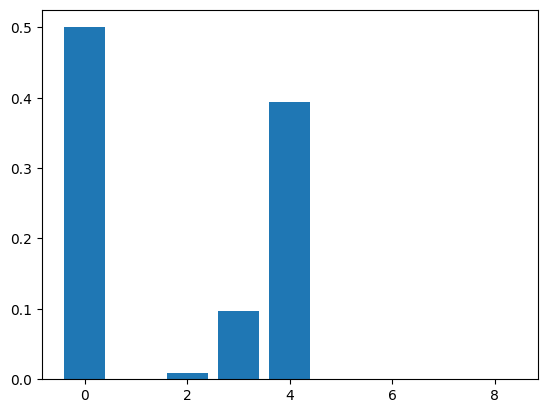

In [14]:
plt.bar(np.arange(N), np.abs(np.diag(noisy_binomial_list[-1])))

In [15]:
if RUN_ALL:
    result_binomial, result_binomial_loss, result_binomial_th = perform_protocol(rho_list, F_list, losses=False)

In [16]:
if RUN_ALL:
    plot_all(t_list, result_binomial, result_binomial_loss, [(result_binomial_th[2],"Without VD"), (result_binomial_th[0], "Theoretical 3-mode"),
                                    (result_binomial_th[1], "Theoretical 4-mode")], (3,0.5), "Binomial state", losses=False)

In [17]:
alpha = np.sqrt(2)
rho_cat = qutip.ket2dm((qutip.coherent(N, alpha) + qutip.coherent(N, -alpha)).unit())

nb_samples_cat = 7
t_list_cat = t_list[:nb_samples_cat]
noisy_cat_list = create_states(t_list_cat, rho_cat)
if RUN_ALL:
    result_cat, result_cat_loss, result_cat_th = perform_protocol(noisy_cat_list, F_list[:nb_samples_cat], [1,3], losses=False)
# takes 20 seconds

In [18]:
if RUN_ALL:
    plot_all(t_list_cat, result_cat, result_cat_loss, [(result_cat_th[0], "No VD"), (result_cat_th[1], "Theoretical 3-mode")], (6,0), "Cat state", losses=False)

### Conclusion
VD works well with binomial state (probably because it is quite similar to Fock states) and doesn’t work at all with cat states. The protocol even theoretically gives a worse result than without VD

# Theoretical plots

In [19]:
nb_points = 1000
nb_curves = 7 # modes, starts at 1
nb_n = 30 # Fock state, starts at 1
gamma_list_complete = np.linspace(0,1,nb_points)
theoretical_curves = np.zeros((nb_n, nb_curves, nb_points))
names = [["" for j in range(nb_curves)] for i in range(nb_n)]

for n_ in range(1,nb_n+1):
    theoretical_curves[n_-1][0] = n_ * np.exp(-gamma_list_complete)
    names[n_-1][0] = f"No VD, state |{n_}>"

temporary = (np.exp(kappa * gamma_list_complete)-1)
for n_ in range(1,nb_n+1):
    for M in range(1,nb_curves):
        numerator = np.zeros_like(gamma_list_complete, dtype='O')
        denominator = np.zeros_like(gamma_list_complete, dtype='O')
        for k in range(n_+1):
            coef = (math.comb(n_, k)**M)
            numerator+=(n_-k)*coef *temporary**(M*k)
            denominator+=coef *temporary**(M*k)
        theoretical_curves[n_-1][M] = numerator/denominator
        names[n_-1][M] = f"{M+1}-mode VD, state |{n_}>"

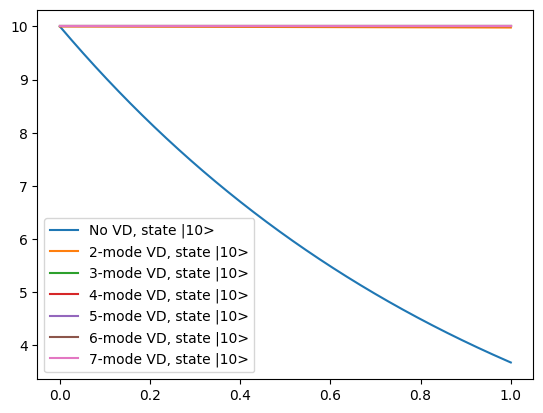

In [20]:
for i in range(9,10):
    for j in range(nb_curves):
        plt.plot(gamma_list_complete, theoretical_curves[i][j], label=names[i][j])
plt.legend()

0.10010010010010009


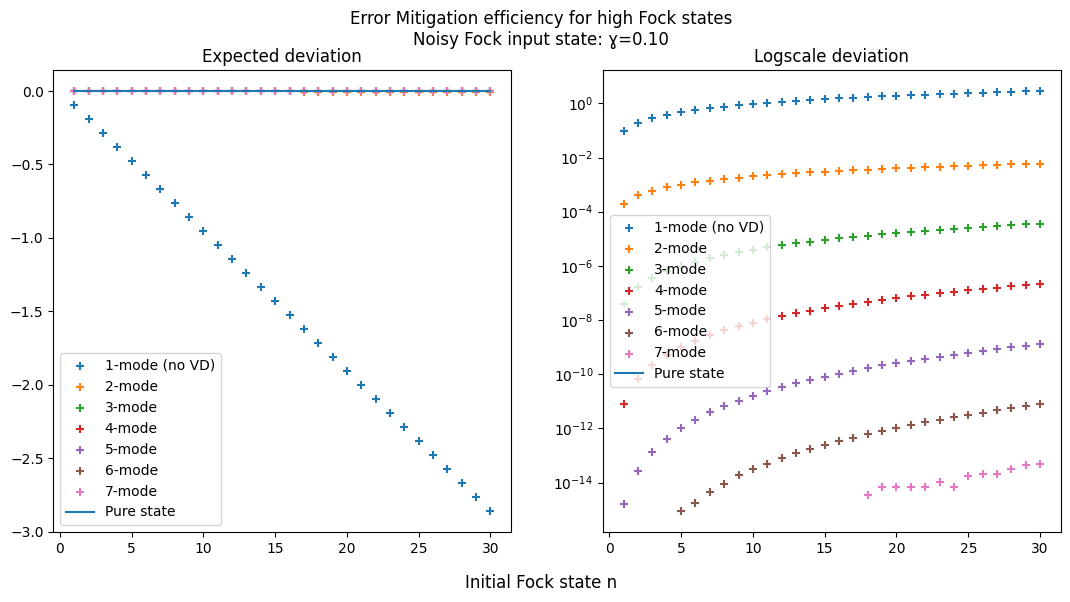

In [21]:
f, axes = plt.subplots(1, 2, figsize=(13,6))
fixed_gamma_index=100
for j in range(nb_curves):
    axes[0].scatter(np.arange(1,nb_n+1), theoretical_curves[:,j,fixed_gamma_index] -np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
    axes[1].scatter(np.arange(1,nb_n+1), -theoretical_curves[:,j,fixed_gamma_index] + np.arange(1,nb_n+1),
                marker='+', label=f"{j+1}-mode" + (" (no VD)" if (j==0) else ""))
axes[0].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )
axes[1].plot(np.arange(1,nb_n+1), np.full((nb_n), 0), label="Pure state" )

axes[0].legend()
axes[0].set_title("Expected deviation")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Logscale deviation")

f.supxlabel("Initial Fock state n")
f.suptitle(f"Error Mitigation efficiency for high Fock states\nNoisy Fock input state: ɣ={gamma_list_complete[fixed_gamma_index]:.2f}")

print(gamma_list_complete[fixed_gamma_index])

On the right plot we see pretty clearly the exponential scaling of the correction as the number of modes increases. In fact, the spacing is the same between each curve, because we are looking at $\log(p^M)=M*\log p$ for different values of M.

We also see that the deviation seems to stabilize, but looking at the left plot it rather seems that it grows linearly with $n$.

In [25]:
a = -theoretical_curves[:,j,fixed_gamma_index] + np.arange(1,nb_n+1)


0.10010010010010009


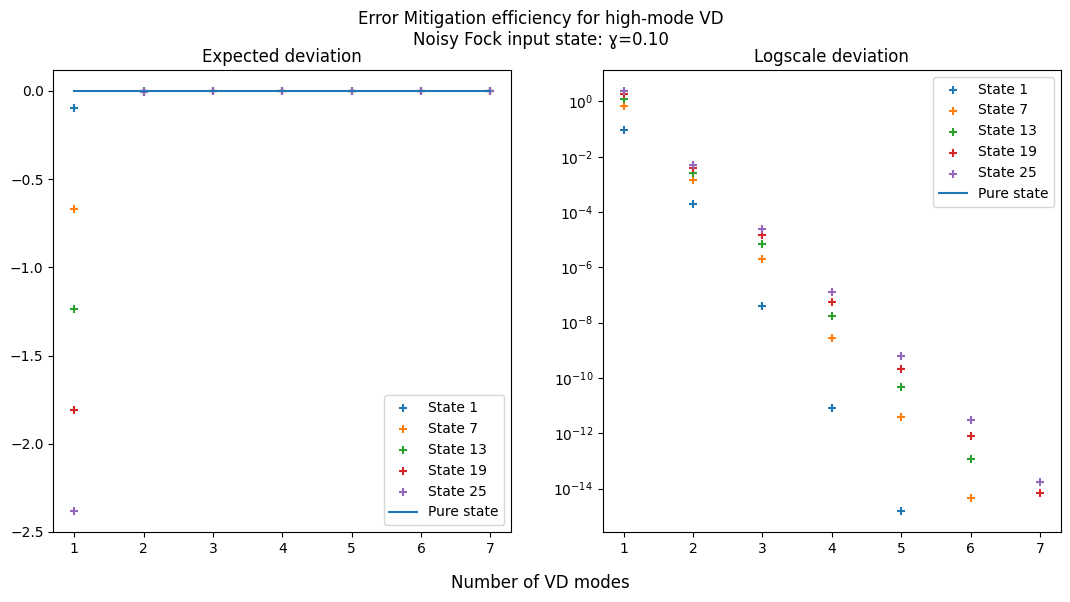

In [23]:
f, axes = plt.subplots(1, 2, figsize=(13,6))
fixed_gamma_index=100
for i in range(0,nb_n, 6):
    axes[0].scatter(np.arange(1,nb_curves+1), theoretical_curves[i,:,fixed_gamma_index] - (i+1),
                marker='+', label=f"State {i+1}")
    axes[1].scatter(np.arange(1,nb_curves+1), -theoretical_curves[i, :,fixed_gamma_index] +(i+1),
                marker='+', label=f"State {i+1}")
axes[0].plot(np.arange(1,nb_curves+1), np.full((nb_curves), 0), label="Pure state" )
axes[1].plot(np.arange(1,nb_curves+1), np.full((nb_curves), 0), label="Pure state" )

axes[0].legend()
axes[0].set_title("Expected deviation")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Logscale deviation")

f.supxlabel("Number of VD modes")
f.suptitle(f"Error Mitigation efficiency for high-mode VD\nNoisy Fock input state: ɣ={gamma_list_complete[fixed_gamma_index]:.2f}")

print(gamma_list_complete[fixed_gamma_index])

Text(0, 0.5, 'Coefficient')

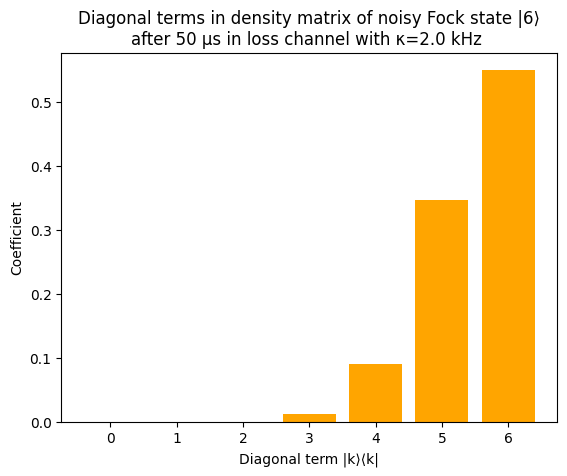

In [24]:
N=10
n=6
t=50
rho = create_states([t], qutip.fock_dm(N,n), 1)[0]
plt.bar(np.arange(n+1),np.abs(np.diag(rho))[:n+1], color='orange', linestyle='-')
plt.title(f"Diagonal terms in density matrix of noisy Fock state |{n}⟩\nafter {t} μs in loss channel with κ={1000*kappa} kHz ")
plt.xlabel("Diagonal term |k⟩⟨k|")
plt.ylabel("Coefficient")